<a href="https://colab.research.google.com/github/randreove/Lumen-detection-system/blob/main/Actividad_C1_P1_AndreoDeLaVega_Rafael.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

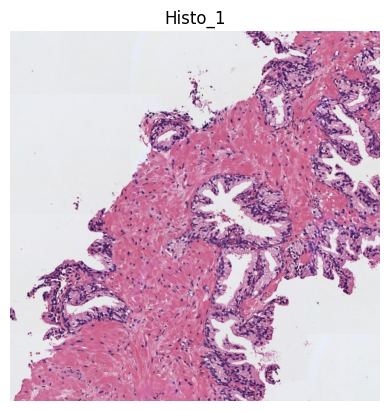

In [ ]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
image = io.imread('histo_1.jpg')

# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
image_normalized = image / 255.0

# Visualizar la imagen
plt.imshow(image_normalized)
plt.axis('off')
plt.title('Histo_1')
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

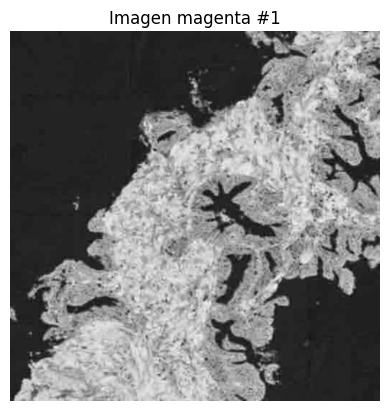

In [ ]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta

#!pip install colorspacious
from colorspacious import cspace_convert

# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
image_cmyk = cspace_convert(image_normalized, start='sRGB1', end='CIELab')
magenta_channel = image_cmyk[:, :, 1]

# Visualizar la imagen del canal magenta
plt.imshow(magenta_channel, cmap='gray')
plt.axis('off')
plt.title('Imagen magenta #1')
plt.show()


#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

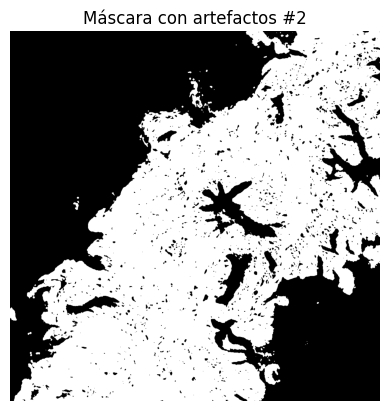

In [ ]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante
from skimage.filters import gaussian, threshold_otsu
from skimage import img_as_ubyte, color

# Aplicar un filtro gaussiano de tamaño 5x5
image_smoothed = gaussian(image_normalized, sigma=1, channel_axis=-1)

# Convertir la imagen a escala de grises
image_gray = color.rgb2gray(image_smoothed,)

# Convertir la imagen a uint8
image_uint8 = img_as_ubyte(image_gray)

# Aplicar el método de Otsu para obtener el umbral
threshold_value = threshold_otsu(image_uint8)

# Umbralizar la imagen
binary_mask = image_uint8 <= threshold_value

# Visualizar la máscara resultante
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')
plt.title('Máscara con artefactos #2')
plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

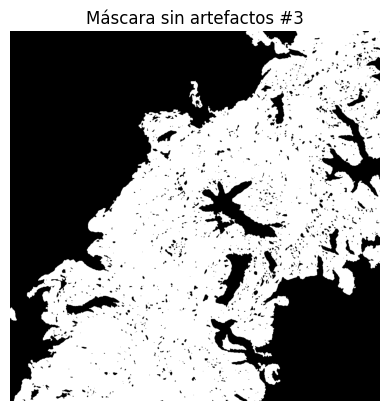

In [ ]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante
from skimage.morphology import remove_small_objects

# Eliminar objetos pequeños
cleaned_mask = remove_small_objects(binary_mask, min_size=300)

# Visualizar la máscara resultante
plt.imshow(cleaned_mask, cmap='gray')
plt.axis('off')
plt.title('Máscara sin artefactos #3')
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

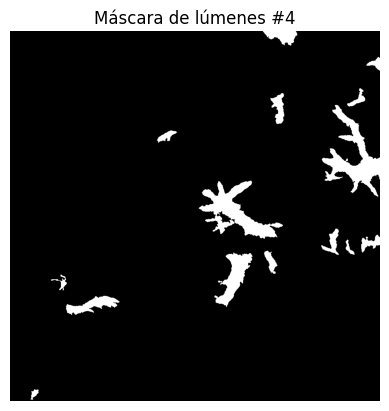

In [ ]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
from skimage.segmentation import flood_fill

# Fijar las semillas manualmente y realizar el rellenado de lúmenes usando flood fill con dichas semillas
seed1, seed2 = (0, 0), (1000, 1000)
lumen_mask = flood_fill(cleaned_mask, seed1, 1)
lumen_mask = flood_fill(lumen_mask, seed2, 1)

# Invierto los colores de la imagen y elimino objetos pequeños
lumen_mask = remove_small_objects(~lumen_mask, min_size=300)

# Visualizar la máscara resultante
plt.imshow(lumen_mask, cmap='gray')
plt.axis('off')
plt.title('Máscara de lúmenes #4')
plt.show()

#### 5) Rellenar los objetos de los lúmenes

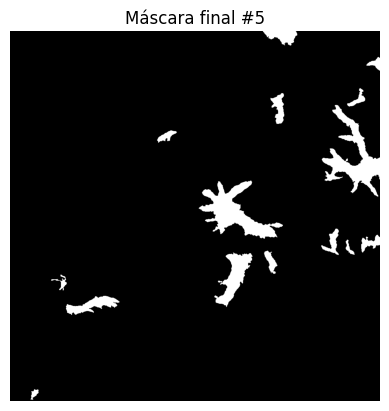

In [ ]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante
from scipy.ndimage import binary_fill_holes

# Rellenar los lúmenes con la función binary_fill_holes
result_mask_filled = binary_fill_holes(lumen_mask)

# Visualizar la máscara resultante
plt.imshow(result_mask_filled, cmap='gray')
plt.axis('off')
plt.title('Máscara final #5')
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

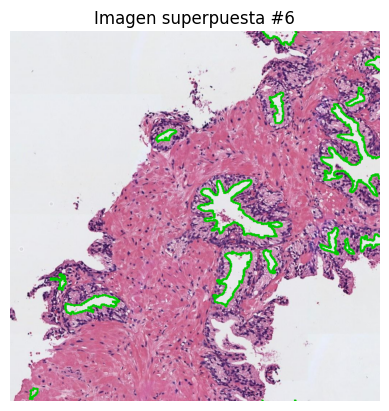

In [ ]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles.
# Visualizar la imagen superpuesta
import numpy as np
from skimage.measure import find_contours
from skimage import draw

# Encontrar los contornos de los lúmenes
contours = find_contours(result_mask_filled, 0.5)

# Crear una imagen de ceros para los contornos dilatados
dilated_contours = np.zeros_like(result_mask_filled, dtype=bool)

# Iterar sobre los contornos y engrosarlos
for contour in contours:
    contour = np.around(contour).astype(int)
    for pixel in contour:
        rr, cc = draw.disk(pixel, radius=3)
        dilated_contours[rr-2, cc-2] = True

# Colorear los contornos dilatados en verde en la imagen original
image[dilated_contours, :] = [0, 200, 0]  # Color verde

# Visualizar la imagen resultante con los contornos en verde y más gruesos
plt.imshow(image)
plt.axis('off')
plt.title('Imagen superpuesta #6')
plt.show()

#### 7) Identificar y cropear el lumen más grande

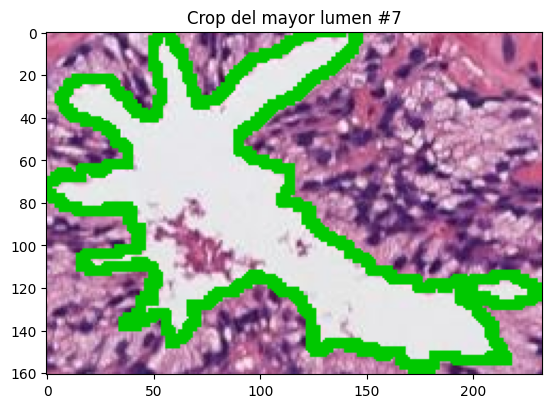

In [ ]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.
from skimage import measure

# Defino las etiquetas de los lúmenes
labels = measure.label(result_mask_filled)

#Obtengo las propiedades de los lúmenes
props = measure.regionprops(labels, image)

# Busco el lumen más grande
largest_lumen = props[0]
for i in props:
    if i.area>largest_lumen.area:
        largest_lumen = i

# Obtener las coordenadas del lumen más grande
min_row, min_col, max_row, max_col = largest_lumen.bbox

# Recortar la porción correspondiente de la imagen original
cropped_lumen = image[min_row:max_row, min_col:max_col]

# Visualizar el lumen más grande cropeado
plt.imshow(cropped_lumen)
plt.title('Crop del mayor lumen #7')
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado

In [ ]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
print("Características geométricas del lumen de mayor área:")

# 1) Área
area = round(largest_lumen.area, 4)
print("Área:", area)

# 2) Área de la bounding box
bbox_area = round(largest_lumen.bbox_area, 4)
print("Área de la bounding box:", bbox_area)

# 3) Área convexa
convex_area = round(largest_lumen.convex_area, 4)
print("Área convexa:", convex_area)

# 4) Exentricidad
eccentricity = round(largest_lumen.eccentricity, 4)
print("Excentricidad:", eccentricity)

# 5) Diámetro equivalente
equivalent_diameter = round(largest_lumen.equivalent_diameter, 4)
print("Diámetro equivalente:", equivalent_diameter)

# 6) Extensión
extent = round(largest_lumen.extent, 4)
print("Extensión:", extent)

# 7) Diámetro Feret
feret_diameter_max = round(largest_lumen.feret_diameter_max, 4)
print("Diámetro Feret máximo:", feret_diameter_max)

# 8) Longitud del eje mayor
major_axis_length = round(largest_lumen.major_axis_length, 4)
print("Longitud del eje mayor:", major_axis_length)

# 9) Longitud del eje menor
minor_axis_length = round(largest_lumen.minor_axis_length, 4)
print("Longitud del eje menor:", minor_axis_length)

# 10) Orientación
orientation = round(largest_lumen.orientation, 4)
print("Orientación:", orientation)

# 11) Perímetro
perimeter = round(largest_lumen.perimeter, 4)
print("Perímetro:", perimeter)

# 12) Solidez
solidity = round(largest_lumen.solidity, 4)
print("Solidez:", solidity)

# 13) Compacidad
compactness = round(4*np.pi*area/(perimeter ** 2), 4)
print("Compacidad:", compactness)

Características geométricas del lumen de mayor área:
Área: 13355.0
Área de la bounding box: 37513.0
Área convexa: 27407.0
Excentricidad: 0.8445
Diámetro equivalente: 130.3998
Extensión: 0.356
Diámetro Feret máximo: 243.0165
Longitud del eje mayor: 231.3555
Longitud del eje menor: 123.9157
Orientación: 0.9963
Perímetro: 1158.8986
Solidez: 0.4873
Compacidad: 0.125
